<a href="https://colab.research.google.com/github/Markvarte/EEG_analyzer/blob/master/eeg_analyzer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# path: /content/EEG_A.edf -> https://zenodo.org/records/160118
# sleep-edf database -> https://www.physionet.org/content/sleep-edfx/1.0.0/sleep-telemetry/#files-panel
# child-edf database -> https://physionet.org/content/chbmit/1.0.0/chb01/#files-panel
# https://hypnodynecorp.com/downloads.php ? some kind of edf DB too?
# additional: pip install mne, braindecode

In [21]:
%matplotlib tk

In [1]:
import mne
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np
from braindecode.models import EEGNetv4 as EEGNet

In [2]:
raw = mne.io.read_raw_edf("Data/chb01_01.edf", preload=True)
data = raw.get_data()


Extracting EDF parameters from /home/ik-edit/Documents/EEG_analysis/EEG_analyzer/Data/chb01_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


/tmp/ipykernel_17011/694406256.py:1: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf("Data/chb01_01.edf", preload=True)


In [31]:
raw.info

<Info | 8 non-empty values
 bads: []
 ch_names: FP1-F7, F7-T7, T7-P7, P7-O1, FP1-F3, F3-C3, C3-P3, P3-O1, ...
 chs: 23 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 128.0 Hz
 meas_date: 2076-11-06 11:42:54 UTC
 nchan: 23
 projs: []
 sfreq: 256.0 Hz
 subject_info: <subject_info | his_id: Surrogate>
>

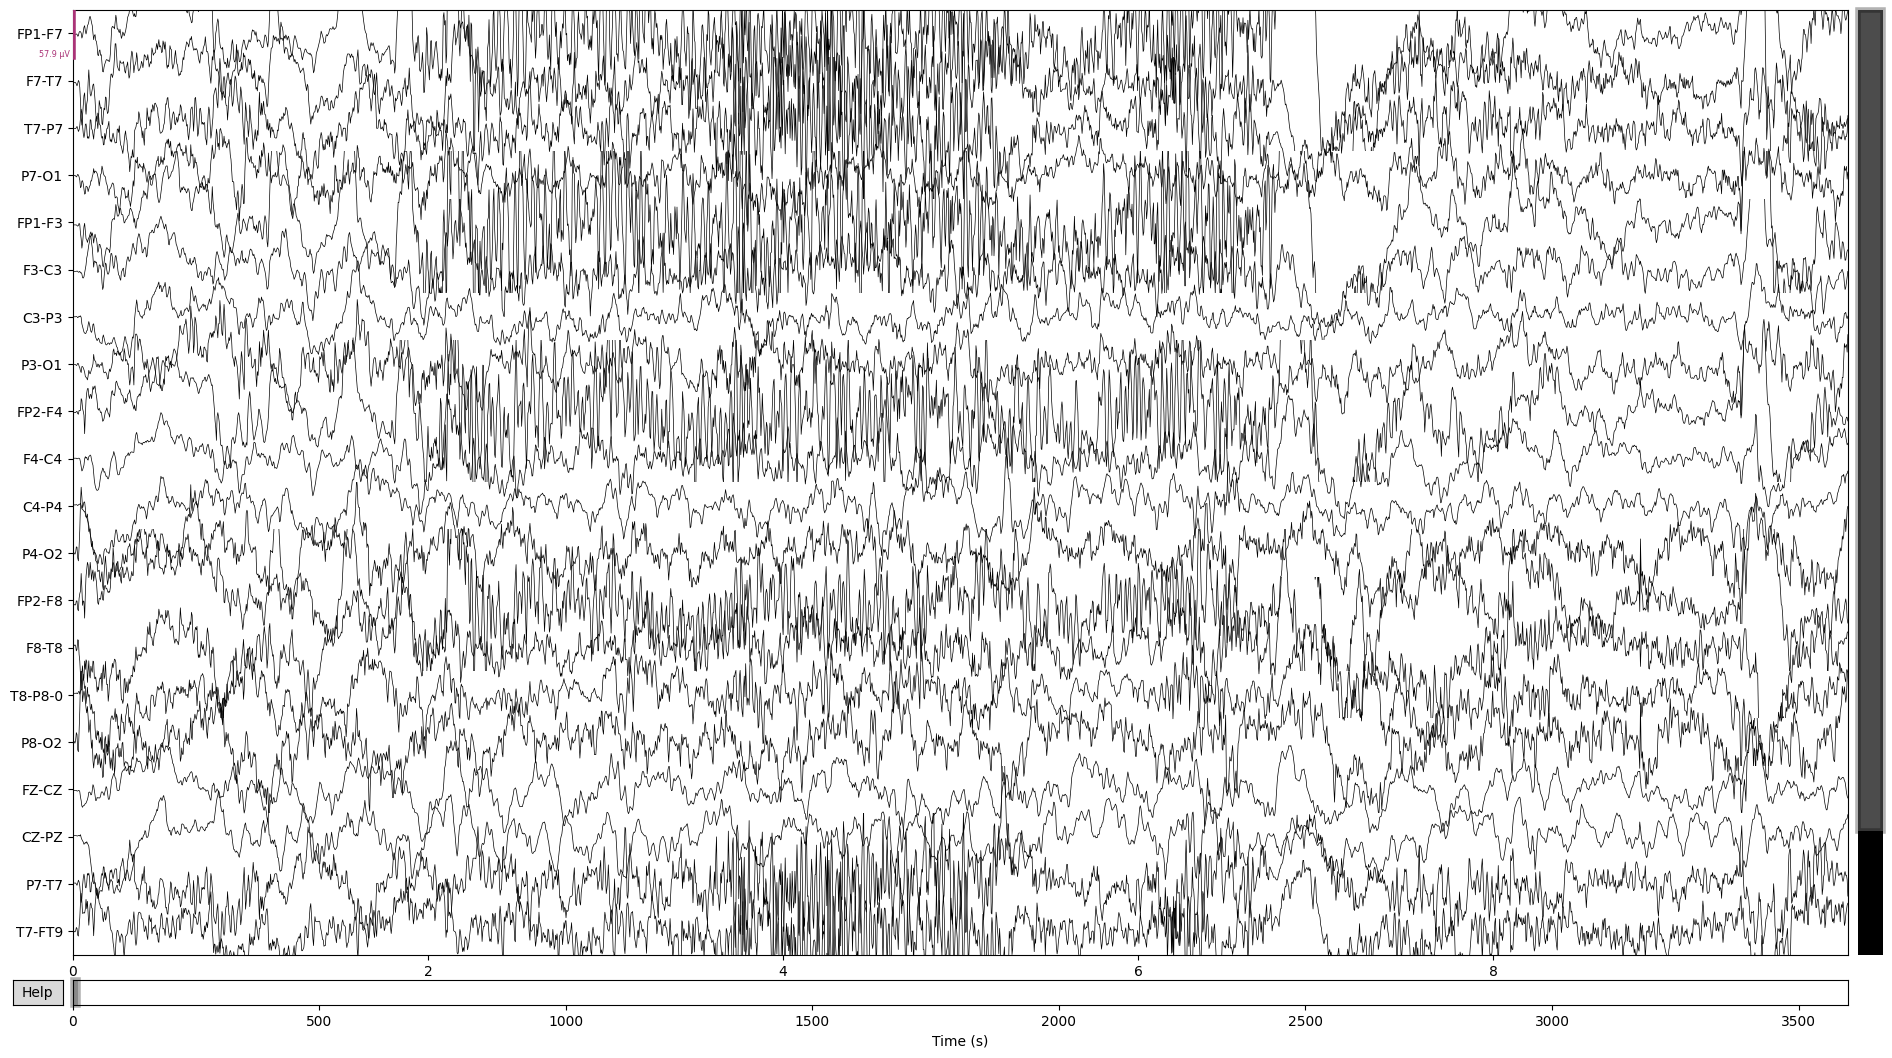

In [23]:
raw.plot(scalings='auto', show=True)

In [11]:
# filtering data

# raw_resampled = raw.copy().resample(256) (already have)
raw_resampled = raw.copy()

# Убираем дрейф и ВЧ-шум → 0.5–45 Гц, мышечные артефакты (EMG), движение кожи
raw_filtered = raw_resampled.copy().filter(l_freq=0.5, h_freq=45)

# Удаление сетевой наводки (50 Гц)
raw_filtered.notch_filter(freqs=[50])

# Референцированиe
# Пересчёт в среднее по всем каналам
raw_filtered.set_eeg_reference('average')

# можно попробовать для допю очистки ICA(Independent Component Analysis) - моргания, движение глаз (EOG)
# мышечная активность (EMG), сердечные артефакты (ECG)
# явные EOG или резкие скачки через mne.preprocessing.find_bads_eog

# Нормализация
data = raw_filtered.get_data()  # [n_channels, n_times]
# Z-score по каналам -убрать индивидуальные различия каналов по масштабу, сделать данные сопоставимыми
data_zscored = (data - data.mean(axis=1, keepdims=True)) / data.std(axis=1, keepdims=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1691 samples (6.605 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband e

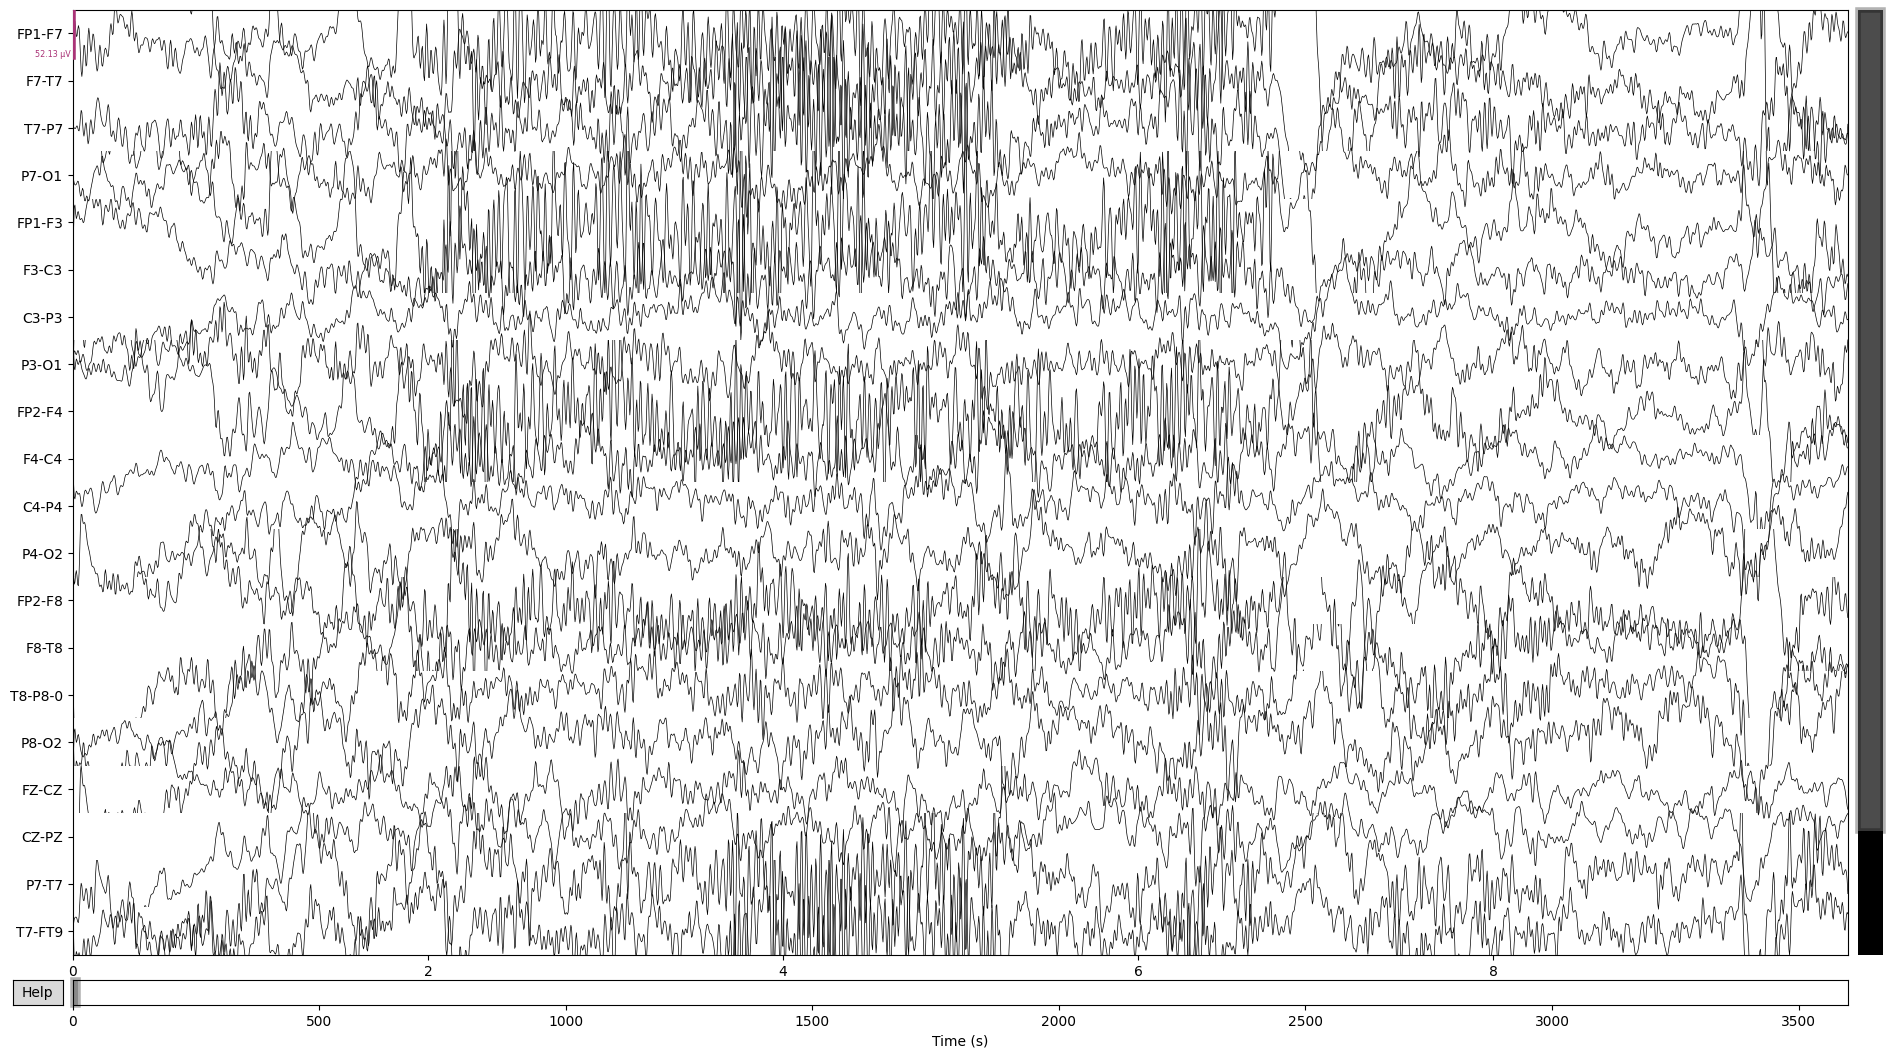

In [24]:
raw_filtered.plot(scalings='auto', show=True)

In [27]:
def get_filtered_data(raw):
    
    raw_resampled = raw.copy().resample(256)
    
    # Убираем дрейф и ВЧ-шум → 0.5–45 Гц, мышечные артефакты (EMG), движение кожи
    raw_filtered = raw_resampled.copy().filter(l_freq=0.5, h_freq=45)
    
    # Удаление сетевой наводки (50 Гц)
    raw_filtered.notch_filter(freqs=[50])
    
    # Референцированиe
    # Пересчёт в среднее по всем каналам
    raw_filtered.set_eeg_reference('average')
    # дополнительно можно ICA -> find_bads_eog
    
    # Нормализация
    data = raw_filtered.get_data()  # [n_channels, n_times]
    # Z-score по каналам -убрать индивидуальные различия каналов по масштабу, сделать данные сопоставимыми
    data_zscored = (data - data.mean(axis=1, keepdims=True)) / data.std(axis=1, keepdims=True)
    return data_zscored

Channels marked as bad:
none
Channels marked as bad:
none


In [28]:
# window_size: зависит от частоты дискретизации
# частота записи ЕЕГ в 512 герц -> окно в 2 секунду
# частота записи ЕЕГ в 256 герц -> окно в 1 секунды
class EEGDataset(Dataset):
    def __init__(self, file_list, window_size=512, cut_step=256):
        self.samples = []
        for f in file_list:
            raw = mne.io.read_raw_edf(f, preload=True)
            # filter raw record, return some numpy obj
            data = get_filtered_data(raw)
            # режем на куски фиксированного размера
            # возможны несколько стратегий- без overlap, c overlap, c padding.
            # тут с overlap- шаг 256, окно 512
            # пример- [0:512], [256:512+256(768)], [512:768+256(1024)], ...
            for start in range(0, data.shape[1]-window_size, cut_step):
                segment = data[:, start:start+window_size]
                self.samples.append(segment.astype(np.float32))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        x = self.samples[idx]
        # SimCLR-style аугментации
        # проверить правильность !
        def augment(sig):
            # лучайный нормальный гаусовский шум с дисперсией 0.01
            sig = sig + 0.01*np.random.randn(*sig.shape)
            # сдвигает сигнал по временной оси на случайное число отсчётов от -10 до 9
            sig = np.roll(sig, np.random.randint(-10, 10), -1)
            return sig
        return augment(x), augment(x)

In [30]:
# Contrastive Loss
def contrastive_loss(z1, z2, temperature=0.5):
    z1 = F.normalize(z1, dim=1)
    z2 = F.normalize(z2, dim=1)
    representations = torch.cat([z1, z2], dim=0)
    similarity_matrix = torch.matmul(representations, representations.T)
    labels = torch.arange(z1.size(0)).repeat(2)
    labels = (labels.unsqueeze(0) == labels.unsqueeze(1)).float()
    mask = torch.eye(labels.shape[0], dtype=torch.bool)
    labels = labels[~mask].view(labels.shape[0], -1)
    similarity_matrix = similarity_matrix[~mask].view(similarity_matrix.shape[0], -1)
    positives = similarity_matrix[labels.bool()].view(labels.shape[0], -1)
    negatives = similarity_matrix[~labels.bool()].view(labels.shape[0], -1)
    logits = torch.cat([positives, negatives], dim=1)
    labels = torch.zeros(logits.shape[0], dtype=torch.long).to(z1.device)
    logits = logits / temperature
    return F.cross_entropy(logits, labels)


In [38]:
# Backbone (EEGNet)
backbone = EEGNet(
    n_chans=23,                 # число каналов
    n_outputs=128,              # эмбеддинги
    n_times=512,
    final_conv_length='auto'
)

# убираем head → используем только фичи
backbone.classify = False
backbone = backbone.cuda()

optimizer = torch.optim.Adam(backbone.parameters(), lr=1e-3)

# ====== Обучение ======
dataset = EEGDataset(["Data/chb01_01.edf", "Data/chb01_02.edf", "Data/chb01_03.edf"])
loader = DataLoader(dataset, batch_size=64, shuffle=True)

for epoch in range(10):
    for x1, x2 in loader:
        x1 = x1.float().cuda()
        x2 = x2.float().cuda()

        print(x1.shape)
        
        z1 = backbone(x1)  # эмбеддинги
        z2 = backbone(x2)
        loss = contrastive_loss(z1, z2)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch} | Loss {loss.item():.4f}")

torch.save(backbone.state_dict(), "backbone_ssl.pt")

Extracting EDF parameters from /home/ik-edit/Documents/EEG_analysis/EEG_analyzer/Data/chb01_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...
Sampling frequency of the instance is already 256.0, returning unmodified.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1691 samples (6.605 s)



/tmp/ipykernel_17011/3050122364.py:8: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(f, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1691 samples (6.605 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Extracting EDF parameters from /home/ik-edit/Documents/EEG_analysis/EEG_analyzer/Data/chb01_02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...
Sampling frequency of the instance is already 256.0, returning unmodified.
Filterin

/tmp/ipykernel_17011/3050122364.py:8: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(f, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1691 samples (6.605 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Extracting EDF parameters from /home/ik-edit/Documents/EEG_analysis/EEG_analyzer/Data/chb01_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...
Sampling frequency of the instance is already 256.0, returning unmodified.
Filterin

/tmp/ipykernel_17011/3050122364.py:8: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(f, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1691 samples (6.605 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
torch.Size([64, 23, 512])
torch.Size([64, 23, 512])
torch.Size([64, 23, 512])
torch.Size([64, 23, 512])
torch.Size([64, 23, 512])
torch.Size([64, 23, 512])
torch.Size([64, 23, 512])
torch.Size([64, 23, 512])
torch.Size([64, 23, 512])
torch.Size([64, 23, 512])
torch.Size([64, 23, 512])
torch.Size([64, 23, 512])
torch.Size([6